# Initialize and load all info

In [ ]:
class Sample:

    """
    This class defines and describe the samples from k-seq experiments
    """
    
    def __init__(self):
        pass

import sys
import numpy as np

def basic_info(countFileRoot):
    from os import listdir
    from os.path import isfile, join
    
    sampleList = [f for f in listdir(countFileRoot) if isfile(join(countFileRoot, f))]
    sort_fn = lambda s: (int(s.split('_')[1][1:]))
    sampleList.sort(key=sort_fn)
    return countFileRoot, sampleList

def load_sampleSet(root, sampleList, strictLen=False, sampleSetDirc=None):
    import util
    
    def decode_sample_info(sample):
        import re
        
        sample.label = sample.dirc[sample.dirc.rfind('/') + 1:sample.dirc.find('_counts')]
        regex = re.compile(r'S\d+')
        sample.id = int(regex.findall(sample.label)[0][1:])
        if 'Input' in sample.label or 'input' in sample.label:
            sample.sampleType = 'input'
            sample.batch = 0
            sample.seriesPoint = 0
        else:
            sample.sampleType = 'k-seq'
            regex = re.compile(r'-\d+_')
            sample.batch = int(regex.findall(sample.label)[0][1:-1])
            regex = re.compile(r'-\d+-')
            sample.seriesPoint = float(regex.findall(sample.label)[0][1:-1])
       
        return sample
        
    def import_count_file(sample):
        """
        :param dirc:
        :param sampleType:
        :return:
        """
        with open(sample.dirc, 'r') as file:
            sample.uniqueSeq = int([elem for elem in next(file).strip().split()][-1])
            sample.totalSeq = int([elem for elem in next(file).strip().split()][-1])
            next(file)
            sample.seqs = {}
            for line in file:
                seq = line.strip().split()
                sample.seqs[seq[0]] = int(seq[1])
        return sample

    def survey_ext_std(sample, strictLen=False, stdSeq='AAAAACAAAAACAAAAACAAA', maxDist=10):
        """
        This method will survey the spike in sequences in each sample
        :param stdSeq:
        :return:
        """
        import Levenshtein
        sample.stdCounts = np.array([0 for _ in range(maxDist+1)])
        for seq in sample.seqs.keys():
            dist = Levenshtein.distance(stdSeq, seq)
            if strictLen:
                if (dist <= maxDist)and(len(seq)==21):
                    sample.stdCounts[dist] += sample.seqs[seq]
            else:
                if dist <= maxDist:
                    sample.stdCounts[dist] += sample.seqs[seq]
        return sample

    if sampleSetDirc:
        sampleSet = util.load_pickle(sampleSetDirc)
    else:
        sampleSet = []
        for sample in sampleList:
            currentSample = Sample()
            currentSample.dirc = root + sample
            currentSample = decode_sample_info(currentSample)
            currentSample = import_count_file(currentSample)
            currentSample = survey_ext_std(currentSample, maxDist=16)
            sampleSet.append(currentSample)

    return sampleSet


countFileRoot, sampleList = basic_info(countFileRoot='/mnt/storage/projects/k-seq/input/yc_byo/outside_vesicle/counts/')

sampleSet = load_sampleSet(root=countFileRoot, strictLen=True, sampleList=sampleList)

# Overview of the sample

id,sample label,total counts,unique sequences,ext. std. counts,ext. std. percent
1,Input_S1,"3,649,408","373,403","429,237",0.118
2,BYO-0-1_S2,"3,390,487","1,196,693","1,073,659",0.317
3,BYO-0-2_S3,"4,373,487","3,691,270","113,325",0.026
4,BYO-0-3_S4,"3,854,430","2,771,468","307,946",0.080
5,BYO-10-1_S5,"4,107,236","2,069,723","478,430",0.116
11,BYO-10-2_S11,"4,210,609","2,051,746","544,707",0.129
12,BYO-10-3_S12,"4,318,440","2,510,344","179,398",0.042
13,BYO-50-1_S13,"4,137,830","2,102,581","80,134",0.019
14,BYO-50-2_S14,"573,277","443,821","22,915",0.040
15,BYO-50-3_S15,"3,670,327","1,132,096","100,957",0.028


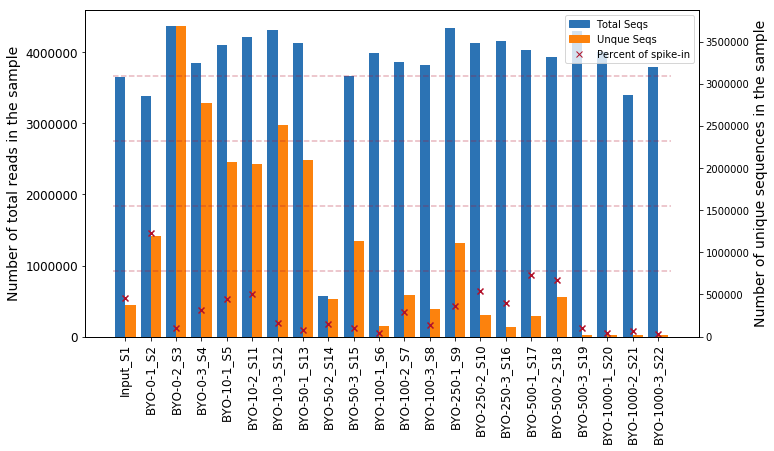

In [9]:
def print_sample_overview(sampleSet, sort_fn=None, table=False, figures=True, figSaveDirc=None):
    if sort_fn:
        sampleSet.sort(key=sort_fn)
    
    if table:
        from IPython.display import HTML
        tableHTML = """
        <table>
        <tr>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        </tr>
        """.format(
            'id',
            'sample label',
            'total counts',
            'unique sequences',
            'ext. std. counts',
            'ext. std. percent'
        )
        for ix,sample in enumerate(sampleSet):
            tableHTML += """
            <tr>
            <td>{}</td>
            <td>{}</td>
            <td>{:,}</td>
            <td>{:,}</td>
            <td>{:,}</td>
            <td>{:.3f}</td>
            </tr>
            """.format(
                sample.id,
                sample.label,
                sample.totalSeq,
                sample.uniqueSeq,
                sample.stdCounts[0],
                sample.stdCounts[0] / sample.totalSeq
            )
        display(HTML(tableHTML))

    if figures:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatch
        import plot

        sampleNum = len(sampleSet)
        fig = plt.figure(figsize=[sampleNum * 0.5, 6])
        # Plot bar for total seqs
        ax = fig.add_subplot(111)
        ax.bar(x=[i - 0.2 for i in range(sampleNum)], height=[sample.totalSeq for sample in sampleSet], align='center',
               width=0.4, color='#2C73B4')
        # plot bar for unique seqs
        ax2 = ax.twinx()
        ax2.bar(x=[i + 0.2 for i in range(sampleNum)], height=[sample.uniqueSeq for sample in sampleSet],
                align='center', width=0.4, color='#FC820D')
        # plot scatter for spike-in percentage
        ax3 = ax.twinx()
        ax3.scatter([i for i in range(sampleNum)], [sample.stdCounts[0] / sample.totalSeq for sample in sampleSet],
                    color='#B2112A', marker='x')
        ax3.plot([-0.5, sampleNum - 0.5], [0.2, 0.2], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.4, 0.4], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.6, 0.6], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.8, 0.8], '#B2112A', ls='--', alpha=0.3)
        ax3.set_ylim([0, 1])
        ax3.set_yticks([])

        # Aesthetic adjustment
        ax.set_ylabel('Number of total reads in the sample', fontsize=14)
        ax2.set_ylabel('Number of unique sequences in the sample', fontsize=14)
        ax.set_xticks([i for i in range(sampleNum)])
        ax.set_xticklabels([sample.label for sample in sampleSet], rotation=90)
        plot.set_ticks_size(ax)
        plot.set_ticks_size(ax2)
        lgd = [mpatch.Patch(color='#2C73B4', label='Total Seqs'), mpatch.Patch(color='#FC820D', label='Unque Seqs'),
               plt.plot([], [], lw=0, marker='x', color='#B2112A', label='Percent of spike-in')[0]]
        plt.legend(handles=lgd)

        if figSaveDirc:
            fig.savefig(figSaveDirc, dpi=300)
        plt.show()


sort_fn = lambda sample: (sample.seriesPoint, sample.batch) 
print_sample_overview(sampleSet=sampleSet, sort_fn = sort_fn, table=True, figures=True, figSaveDirc='/mnt/chen-nas/Users/Yuning/k-seq_yc/outside_vesicle/sample_info.jpeg')

## spike-in

<Figure size 432x288 with 0 Axes>

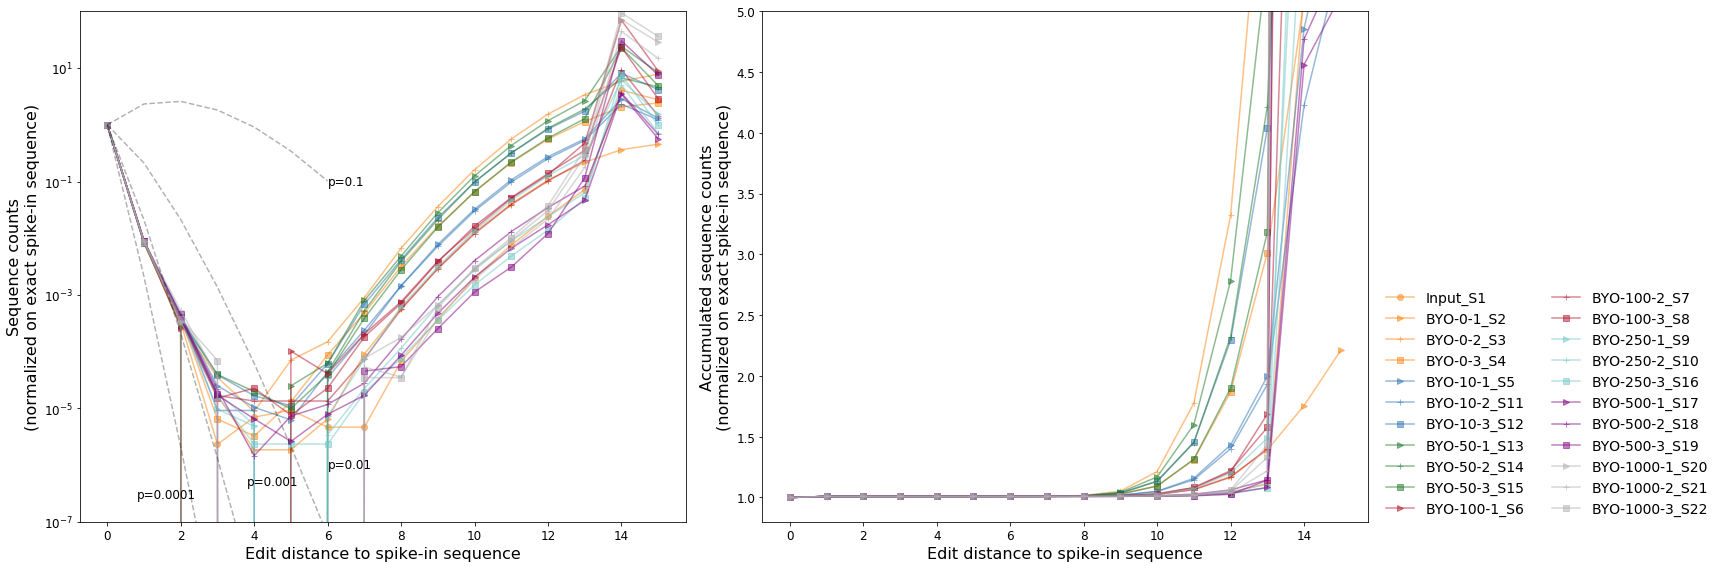

In [11]:
def plot_std_peak_dist(sampleSet, sort_fn=None, norm=True, maxDist=15):
    import matplotlib.pyplot as plt
    
    if sort_fn:
        sampleSet.sort(key=sort_fn)
        
    markerList = ['-o', '->', '-+', '-s']  # different marker for different replicates
    colorMapping = {
        0: '#FC820D',
        10: '#2C73B4',
        50: '#1C7725',
        100: '#B2112A',
        250: '#70C7C7',
        500: '#810080',
        1000: '#AEAEAE'
    }
          # different color for different type of samples
        
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=[24, 8])

    for sample in sampleSet:
        counts = sample.stdCounts[:maxDist+1]
        countsNormed = counts/counts[0]
        ax[0].plot([i for i in range(maxDist + 1)], countsNormed,
                   markerList[sample.batch], color=colorMapping[sample.seriesPoint],
                   label=sample.label, alpha=0.5)

    # add binomial distribution guide line
    pList = [0.1, 0.01, 0.001, 0.0001]
    from scipy.stats import binom
    for p in pList:
        rv = binom(21, p)
        pmfs = np.array([rv.pmf(x) for x in range(7)])
        pmfsNormed = pmfs/pmfs[0]
        ax[0].plot([i for i in range(7)], pmfsNormed, color='k', ls = '--', alpha=0.3)
    ax[0].text(s='p=0.1', x=6, y=1e-1, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.01', x=6, y=1e-6, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.001', x=3.8, y=5e-7, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.0001', x=0.8, y=3e-7, ha='left', va='center', fontsize=12)

    ax[0].set_xlabel('Edit distance to spike-in sequence', fontsize=16)
    ax[0].set_yscale('log')
    ax[0].set_ylim([1e-7, 100])
    ax[0].tick_params(labelsize=12)
    ax[0].set_ylabel('Sequence counts\n(normalized on exact spike-in sequence)', fontsize=16)

    for sampleIx, sample in enumerate(sampleSet):
        counts = sample.stdCounts[:maxDist+1]
        countsAccumulated = np.array([np.sum(counts[:i+1]) for i in range(maxDist + 1)])
        countsAccumulatedNormed = countsAccumulated/countsAccumulated[0]
        ax[1].plot([i for i in range(maxDist + 1)], countsAccumulatedNormed,
                   markerList[sample.batch], color=colorMapping[sample.seriesPoint],
                   label=sample.label, alpha=0.5)
    ax[1].set_xlabel('Edit distance to spike-in sequence', fontsize=16)
    ax[1].tick_params(labelsize=12)
    ax[1].set_ylim([0.8, 5])
    ax[1].set_ylabel('Accumulated sequence counts\n(normalized on exact spike-in sequence)', fontsize=16)
    ax[1].legend(loc=[1.02, 0], fontsize=14, frameon=False, ncol=2)
    plt.tight_layout()
    fig.savefig('/mnt/chen-nas/Users/Yuning/k-seq_yc/outside_vesicle/spike-in_dist.jpeg', dpi=300)
    plt.show()

plot_std_peak_dist(sampleSet=sampleSet, maxDist=15)

array([2448115,   20386,     818,      15,       7,       1,       3,
             5,      10,      19,      90,     427,    2349,   21745,
       4310336,  130226,   12540])

In [123]:
for sample in sampleSet:
    print(sample.seriesPoint, '', sample.stdNg)

0  0.5
0.0  0.5
0.0  0.5
0.0  0.5
10.0  0.5
100.0  0.5
100.0  0.5
100.0  0.5
250.0  2
250.0  2
10.0  0.5
10.0  0.5
50.0  0.5
50.0  0.5
50.0  0.5
250.0  2
500.0  4
500.0  4
500.0  4
1000.0  4
1000.0  4
1000.0  4


# Normalization factor

In [205]:
byoNgMap = {
    'input': 500,
    0.0 : 0.5,
    10.0 : 0.5,
    50.0 : 0.5,
    100.0 : 0.5,
    250.0 : 2,
    500.0 : 4,
    1000.0 : 4
}

rnaConcenList = [
    1130,
    0.002, 0.025, 0.023,
    0.75, 0.703, 0.865,
    0.722, 1.645, 0.707,
    1.314, 3.583, 1.961,
    5.316, 18.12, 2.603,
    8.035, 7.852, 6.526,
    8.158, 10.75, 9.517
]

sampleSet[0].seriesPoint = 'input'
for sampleIx, sample in enumerate(sampleSet):
    sample.stdNg = byoNgMap[sample.seriesPoint]
    sample.rnaConcen = rnaConcenList[sampleIx]
    if sampleIx == 0:
        sample.volumeTotal = 92
    else:
        sample.volumeTotal = 82

In [206]:
for sample in sampleSet:
    print(sample.label, ' ', sample.rnaConcen, ' ', sample.volumeTotal)

Input_S1   1130   92
BYO-0-1_S2   0.002   82
BYO-0-2_S3   0.025   82
BYO-0-3_S4   0.023   82
BYO-10-1_S5   0.75   82
BYO-10-2_S11   0.703   82
BYO-10-3_S12   0.865   82
BYO-50-1_S13   0.722   82
BYO-50-2_S14   1.645   82
BYO-50-3_S15   0.707   82
BYO-100-1_S6   1.314   82
BYO-100-2_S7   3.583   82
BYO-100-3_S8   1.961   82
BYO-250-1_S9   5.316   82
BYO-250-2_S10   18.12   82
BYO-250-3_S16   2.603   82
BYO-500-1_S17   8.035   82
BYO-500-2_S18   7.852   82
BYO-500-3_S19   6.526   82
BYO-1000-1_S20   8.158   82
BYO-1000-2_S21   10.75   82
BYO-1000-3_S22   9.517   82


## Distribution of sample pools

In [ ]:
stdSeqList = []
for sample in sampleSet:
    stdSeqList += data.get_sequence_cluster(sample=sample, center='AAAAACAAAAACAAAAACAAA', maxDist=2).keys()
stdSeqList = set(stdSeqList)

In [ ]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample' + util.color.END)


def get_seq_length(self, minCounts=1, blackList=None):
        if not blackList:
            blackList = []
        return np.array([len(seq[0]) for seq in self.seqs.items() if (seq[0] not in blackList)and(seq[1] >= minCounts)])

def get_seq_composition(self, fraction=False, minCounts=1, blackList=None):
        if not blackList:
            blackList = []
        seqsNew = np.array([seq[1] for seq in self.seqs.items() if (seq[0] not in blackList)and(seq[1] >= minCounts)])
        if fraction:
            return seqsNew/np.sum(seqsNew)
        else:
            return seqsNew


data.print_length_dist(sampleSet, total=True, unique=True, blackList=stdSeqList)

In [91]:
sample.stdCounts[:2]

array([2448115,   20386])

In [48]:
sampleSet[0].label

'Input_S3'

# Extract valid sequences

In [208]:
import Levenshtein

def get_seq_table(seqs, normed=False, cleanEmpty=True):
    import pandas as pd
    
    seqTable = pd.DataFrame(index=seqs)
    for sample in sampleSet:
        for seq in sample.seqs:
            if seq in seqTable.index:
                if normed:
                    seqTable.loc[seq, sample.label] = sample.seqs[seq]/(sample.totalSeq - np.sum(sample.stdCounts[:3]))*sample.rnaConcen * sample.volumeTotal
                else:
                    seqTable.loc[seq, sample.label] = sample.seqs[seq]    
    if cleanEmpty:
        return seqTable[seqTable.sum(axis=1) > 0]
    else:
        return seqTable
        
stdPeakCutOff = 2
inputSeqSet = [seq for seq in sampleSet[0].seqs.keys() if Levenshtein.distance(seq, 'AAAAACAAAAACAAAAACAAA') > stdPeakCutOff]
inputSeqSet = set(inputSeqSet)
kSeqSeqSet = []
for sample in sampleSet[1:]:
    kSeqSeqSet += list(sample.seqs.keys())
kSeqSeqSet = set(kSeqSeqSet)
seqs = inputSeqSet.intersection(kSeqSeqSet)
print('seqs in input:{}\nseqs in kSeq:{}\nseqs in intersection:{}'.format(len(inputSeqSet), len(kSeqSeqSet), len(seqs)))

seqTableNormed = get_seq_table(seqs=seqs, normed=True)

seqs in input:373278
seqs in kSeq:21155521
seqs in intersection:3474


In [213]:
seqTable.columns

Index(['Input_S1', 'BYO-0-1_S2', 'BYO-0-2_S3', 'BYO-0-3_S4', 'BYO-10-1_S5',
       'BYO-10-2_S11', 'BYO-10-3_S12', 'BYO-50-1_S13', 'BYO-50-2_S14',
       'BYO-50-3_S15', 'BYO-100-1_S6', 'BYO-100-2_S7', 'BYO-100-3_S8',
       'BYO-250-1_S9', 'BYO-250-2_S10', 'BYO-250-3_S16', 'BYO-500-1_S17',
       'BYO-500-2_S18', 'BYO-500-3_S19', 'BYO-1000-1_S20', 'BYO-1000-2_S21',
       'BYO-1000-3_S22'],
      dtype='object')

In [212]:
seqTable.iloc[:20, :]

,Input_S1,BYO-0-1_S2,BYO-0-2_S3,BYO-0-3_S4,BYO-10-1_S5,BYO-10-2_S11,BYO-10-3_S12,BYO-50-1_S13,BYO-50-2_S14,BYO-50-3_S15,...,BYO-100-3_S8,BYO-250-1_S9,BYO-250-2_S10,BYO-250-3_S16,BYO-500-1_S17,BYO-500-2_S18,BYO-500-3_S19,BYO-1000-1_S20,BYO-1000-2_S21,BYO-1000-3_S22
ATTACCCTGGTCATCGAGTGA,54517.255757,8.959926e-04,3.360988e-03,0.037277,15.833944,12.341651,16.211908,22.931079,19.845029,33.925029,...,130.566144,260.991490,1211.763051,183.000727,524.779790,472.074582,422.754584,470.674752,650.346667,556.465554
CTACTTCAAACAATCGGTCTG,32798.124107,3.151368e-04,1.824646e-03,0.013628,0.683507,0.625689,0.821130,1.498917,1.555699,1.960233,...,6.045838,28.243820,79.993861,12.197337,45.778710,42.504380,77.923800,154.709076,171.946089,176.419953
ATTACCCTGGTCATCGAGTGT,2945.274874,4.330287e-05,1.655706e-04,0.001897,0.791998,0.717037,0.926632,1.291082,0.987850,1.820257,...,6.812826,14.346973,66.692587,9.589893,28.805870,27.017001,25.827882,32.198825,43.547548,34.464009
CTGCTTCAAACAATCGGTCTG,101.196756,7.110488e-08,5.294410e-06,0.000030,0.001833,0.001732,0.002794,0.004247,0.003187,0.006547,...,0.017169,0.076129,0.225225,0.035645,0.138086,0.114284,0.298206,0.604452,0.686519,0.678560
CTCCTTCAAACAATCGGTCTG,41.661648,2.133146e-07,2.406550e-06,0.000012,0.000492,0.000425,0.000857,0.001591,0.001226,0.001755,...,0.005926,0.023603,0.066267,0.009882,0.041930,0.044565,0.078448,0.149214,0.166884,0.174398
CCACTTCAAACAATCGGTCTG,29.476666,1.422098e-07,9.626201e-07,0.000011,0.000356,0.000378,0.000686,0.001153,0.000736,0.001235,...,0.005447,0.018506,0.051168,0.007769,0.032455,0.031493,0.053662,0.096550,0.114420,0.118127
TTACTTCAAACAATCGGTCTG,23.206410,3.555244e-07,1.925240e-06,0.000021,0.000373,0.000945,0.000583,0.001547,0.001471,0.001771,...,0.005273,0.030806,0.088077,0.012967,0.049590,0.039217,0.068483,0.112586,0.124702,0.131161
ATCACCCTGGTCATCGAGTGA,22.269104,1.422098e-07,4.813100e-07,0.000015,0.003716,0.002567,0.003669,0.005633,0.004168,0.007489,...,0.033510,0.058731,0.292331,0.046327,0.139295,0.116859,0.097741,0.116637,0.176375,0.141298
ATTACCCTGGTCGTCGAGTGA,21.622686,2.133146e-07,1.925240e-06,0.000019,0.003394,0.002567,0.003652,0.005181,0.002942,0.007473,...,0.031375,0.064937,0.265069,0.039815,0.110872,0.103787,0.096463,0.100432,0.140520,0.116265
ATTACCCTGGACATCGAGTGA,20.879305,3.555244e-07,9.626201e-07,0.000015,0.006380,0.004834,0.006703,0.008479,0.006130,0.013208,...,0.050462,0.097405,0.466388,0.069976,0.210858,0.191134,0.173889,0.175208,0.252567,0.222187


limit_output extension: Maximum message size of 10000 exceeded with 12319 characters

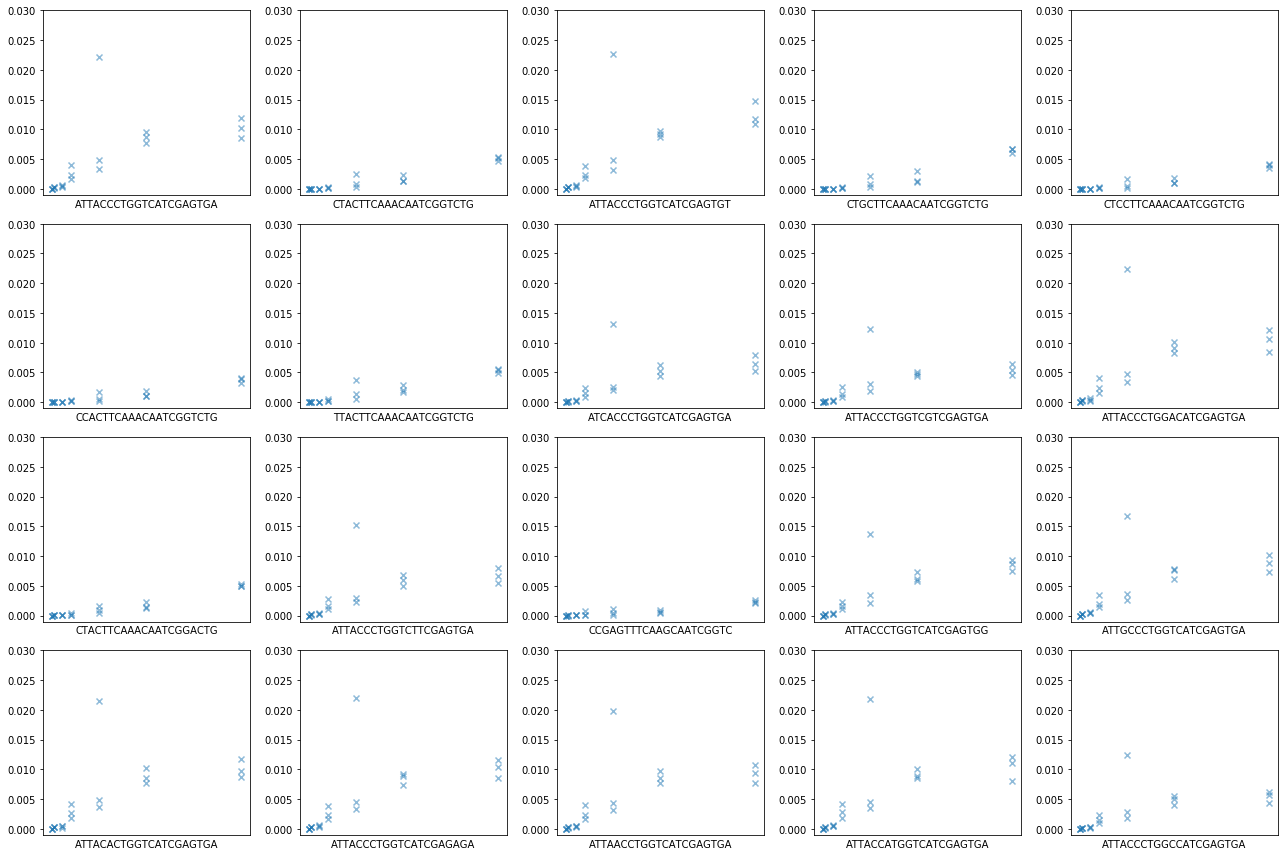

In [222]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(18, 12))
x = [0, 0, 0,
     10, 10, 10,
     50, 50, 50,
     100, 100, 100,
     250, 250, 250,
     500, 500, 500,
     1000, 1000, 1000]

for ix in range(20):
    ax = axes[int(ix/5), ix%5]
    ax.scatter(x, seqTable.iloc[ix, 1:]/seqTable.iloc[ix, 0], marker='x', alpha=0.5)
    ax.set_ylim([-0.001, 0.03])
    ax.set_xlabel(seqTable.index[ix])
    ax.set_xticks([])
plt.tight_layout()
plt.show()
    

In [40]:
seqList['k-seq_detected_times'] = np.sum(~np.isnan(seqList), axis=1)-1
seqList.sort_values(axis='index', by=['k-seq_detected_times', 'Input_S1'], inplace=True, ascending=False)

In [221]:
seqTable.to_csv('/mnt/chen-nas/Users/Yuning/k-seq_yc/outside_vesicle/all_seqs_std_dist2_excluded_normed.csv')

In [127]:
seqList = pd.read_csv('/mnt/chen-nas/Users/Yuning/k-seq_yc/outside_vesicle/all_seqs_std_dist2_excluded.csv', index_col=0)

# Analyze the spike-in peak

In [44]:
import Levenshtein

stdPeakCutOff = 3
inputSeqSet = [seq for seq in sampleSet[0].seqs.keys() if Levenshtein.distance(seq, 'AAAAACAAAAACAAAAACAAA') <= stdPeakCutOff]
print(len(inputSeqSet))
kSeqSeqSet = [[seq for seq in sampleSet[i+1].seqs.keys() if Levenshtein.distance(seq, 'AAAAACAAAAACAAAAACAAA') <= stdPeakCutOff] for i in range(len(sampleSet)-1)]
allDetectedSeq = inputSeqSet.copy()
for sample in kSeqSeqSet:
    allDetectedSeq += sample
allDetectedSeq = set(allDetectedSeq)

126


In [48]:
import pandas as pd
seqList = pd.DataFrame(index=allDetectedSeq)
for sample in sampleSet:
    for seq in sample.seqs:
        if seq in seqList.index:
            seqList.loc[seq, sample.label] = sample.seqs[seq]

In [50]:
seqList['k-seq_detected_times'] = np.sum(~np.isnan(seqList), axis=1)-1
seqList.sort_values(axis='index', by=['k-seq_detected_times', 'Input_S1'], inplace=True, ascending=False)

In [59]:
seqList/seqList.loc['AAAAACAAAAACAAAAACAAA',]*10**5

,Input_S1,BYO-0-1_S2,BYO-0-2_S3,BYO-0-3_S4,BYO-10-1_S5,BYO-10-2_S11,BYO-10-3_S12,BYO-50-1_S13,BYO-50-2_S14,BYO-50-3_S15,...,BYO-250-2_S10,BYO-250-3_S16,BYO-500-1_S17,BYO-500-2_S18,BYO-500-3_S19,BYO-1000-1_S20,BYO-1000-2_S21,BYO-1000-3_S22,k-seq_detected_times,Length
AAAAACAAAAACAAAAACAAA,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0
AAAAACAAAAACAAAAAAAAA,71.056316,74.697832,62.651666,74.038955,63.332149,64.438313,70.234897,62.395488,65.459306,60.421764,...,64.335712,70.767748,68.565477,63.424359,75.336062,58.564408,66.038409,97.635818,100000.0,100000.0
AAAAACAAAAACAAAAACAAT,39.372188,28.128111,27.354953,17.535542,30.307464,24.783966,25.083892,22.462376,52.367445,27.734580,...,40.145484,34.560993,42.657148,42.624685,36.306536,38.194179,53.544656,41.843922,100000.0,100000.0
AAAAACAAAAAAAAAAACAAA,28.189555,36.883219,27.354953,34.421619,36.786991,30.658684,30.658090,42.428932,34.911630,25.753539,...,33.283009,35.736537,33.366787,34.568473,37.214199,28.009065,30.341972,38.356929,100000.0,100000.0
AAAAAAAAAAACAAAAACAAA,24.462010,26.544741,15.001103,18.509739,25.291056,26.803401,17.837434,16.222827,48.003491,20.800935,...,19.558057,22.335336,24.338127,24.461589,24.506912,17.823950,21.417862,31.382942,100000.0,100000.0
GAAAACAAAAACAAAAACAAA,23.064181,31.853689,25.590117,30.200100,29.889430,23.866042,30.658090,31.197744,43.639537,20.800935,...,28.822399,23.275771,30.095534,26.951691,23.599248,33.101622,30.341972,24.408955,100000.0,100000.0
AAAATCAAAAACAAAAACAAA,21.200409,19.559283,16.765939,16.886077,15.885291,17.440569,13.378076,14.974917,13.091861,16.838852,...,20.587428,16.692725,17.533920,18.749002,15.430278,33.101622,16.063397,6.973987,100000.0,100000.0
AAAAACAAAAACAAAAGCAAA,20.734466,21.794629,19.413192,24.030187,24.664005,24.049627,21.181953,17.470737,30.547676,23.772497,...,22.474609,21.630009,23.160476,20.067291,20.876258,12.731393,24.987506,20.921961,100000.0,100000.0
AAAAACAAAAACGAAAACAAA,18.637722,21.608351,21.178028,17.860274,17.139393,19.276418,18.394854,9.983278,21.819769,14.857811,...,22.646171,21.159792,19.889222,21.678534,17.245605,7.638836,10.708931,3.486994,100000.0,100000.0
AAAAACGAAAACAAAAACAAA,18.404751,22.539745,23.825281,18.509739,16.094308,17.991324,16.722594,13.727007,8.727907,18.819894,...,21.273676,17.162942,17.926470,17.577189,19.968595,22.916508,12.493753,13.947974,100000.0,100000.0


limit_output extension: Maximum message size of 10000 exceeded with 32601 characters

In [8]:
import numpy as np
np.power(1e-10,1/10)

0.09999999999999999